## Code to plot Figures 2-5, S1-S4 from Verboncoeur et al. (2024)

### Table of Contents:
data wrangling<br>

(a) Fig 2: figure of dh/dt at 4 time intervals<br>
(b) Fig S1: figure of entire dh/dt time series<br>
(c) Fig S2: RMSE time series<br>
(d) Fig S3: time series of regional dh/dt means that will be removed from the raw dh/dt estimates<br>
(e) Fig 3: figure of dh/dt with means removed (anomalous dh/dt) at 4 time intervals<br>
(f) Fig S4: figure of entire dh/dt time series with regional means removed (anomalous dh/dt)<br>
(g) Fig 4: figure of mean signals within delineated boundaries<br>
(h) Fig 5: figure of anomalous mass estimates<br>

Some final annotations and formatting on figures made in Affinity Designer (https://affinity.serif.com/en-us/designer/). Final versions of figures available on the GitHub repository (https://github.com/hverboncoeur/Verboncoeur2024-JoG/tree/main/figures).

Email hverboncoeur@mines.edu with any questions

In [1]:
# Imports
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import shapefile as shp
from matplotlib import cm
from scipy.stats import sem
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from matplotlib import Path
import matplotlib.path as mpltPath
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon, Point, mapping
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import MultiPolygon
from shapely.geometry.polygon import Polygon
%matplotlib inline

## Data Wrangling

In [2]:
### Load lake outlines

# open lake outlines hdf5 file
lake_outlines = '/Users/hannah/Documents/Research/CraryIceRise/Figure1/SiegfriedFricker2018-outlines.h5'
h5f = h5py.File(lake_outlines, 'r')

outline_geometries = [] # store polygons
# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)
    
    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
    else:
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]
        
        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]
            pgons.append(Polygon(this_outline))
        geometry = MultiPolygon(pgons)
        
    # append all the results in the right place
    outline_geometries.append(geometry)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries), 
                  columns=['name', 'geometry'])
gdf = gpd.GeoDataFrame(df, crs=CRS("EPSG:3031"), geometry=outline_geometries)
h5f.close()

### Mass Balance Calculations
def mass_balance(dhdt,AREA):
    """
    Estimates the mass balance based on the input change in ice thickness over time at data collection points

    Returns:
        - mass balance (in Gt a^-1).
    """
    rho_i = 917 # Density of ice (in kg m^-3)
    avg_thickness_change = np.nanmean(dhdt)
    MB = ((avg_thickness_change * rho_i)*AREA)*1e-12 # AREA in m^2; convert to Gt
    return MB

### Polygon areas
CIR_region = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/Grounded_CIR_region.shp')
MB_cutoff = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/MB_cutoff.shp')
pol_poslg = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/POS_LG.shp')
pol_negsp = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/negspace.shp')
pol_negGL = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/gdf_neg_sm.shp')
WIP = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/WIP.shp')
LCIR = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/MB_cutoff.shp')
POS = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/POS_LG.shp')
NEG = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/merged_neg.shp')
pol_crst = gpd.read_file('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/cyc.shp')
iceshelf = gpd.read_file('/Users/hannah/Documents/Useful Codes & Tools/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
gl=gpd.read_file("/Users/hannah/Documents/Research/CraryIceRise/ICESatCodes/scripps/scripps_antarctica_polygons_v1.shp")

### ATL15 background
ds = xr.open_dataset('/Users/hannah/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/ATL15_dhdt_ICESat2.nc')
x_ = np.asarray(ds.x)
y_ = np.asarray(ds.y)
z_ = np.asarray(ds.Band1)

### Load dh/dt data: ICESat

In [3]:
### Load in ICESat dh/dt data (all dh/dt files located on Zenodo)

# Establish file location of ICESat H5 file
location = "/Users/hannah/Documents/Research/CraryIceRise/ICESatCodes/dhdt_data/"
filename = "dhdt_out_smb.h5"

# extract data you're interested in from ICESat h5
with h5py.File(location+filename, 'r') as f:
    tracks = []
    x = []
    y = []
    dhdt = []
    dt_range_t_fracyr = []
    dt_median_t_fracyr = []
    rmse = []
    for track in f.keys():
        if track == 't1110': # nothing in this track
            continue
        tracks.append(track)
        for data in f[track].attrs.keys():
            if data == 'x':
                x.append(f[track].attrs[data])
            elif data == 'y':
                y.append(f[track].attrs[data])
            elif data == 'dhdt':
                dhdt.append(f[track].attrs[data])
            elif data == 'dt_range_t_fracyr':
                dt_range_t_fracyr.append(f[track].attrs[data])
            elif data == 'dt_median_t_fracyr':
                dt_median_t_fracyr.append(f[track].attrs[data])
            elif data == 'dhdt_rms':
                rmse.append(f[track].attrs[data])

# combine all arrays for each feature
t_is_F = np.concatenate(dt_range_t_fracyr)
x_is_F = np.concatenate(x)
y_is_F = np.concatenate(y)
dhdt_is_F = np.concatenate(dhdt)
rmse_is_F = np.concatenate(rmse)

# filter for low temporal ranges
tmask_F = t_is_F>=5 # 5 year filter; also gets rid of empty tracks/ NaN points
rmse_is_F = rmse_is_F[tmask_F]
x_is_F = x_is_F[tmask_F]
y_is_F = y_is_F[tmask_F]
dhdt_is_F = dhdt_is_F[tmask_F] 
# now you have x, y, and dhdt data with no NaNs

## using the X and Y columns, build a dataframe, then the geodataframe
df1_F = pd.DataFrame({'X':x_is_F, 'Y':y_is_F})
df1_F['coords'] = list(zip(df1_F['X'], df1_F['Y']))
df1_F['coords'] = df1_F['coords'].apply(Point)
gdf1_F = gpd.GeoDataFrame(df1_F, geometry='coords',crs=iceshelf.crs)

### Load dh/dt data: CryoSat-2

In [4]:
### Load in matched CryoSat-2 Swath & POCA dh/dt data (all dh/dt files located on Zenodo)

## Establish file location of 2010-2014 CryoSat-2 file
location = "/Users/hannah/Documents/Research/CraryIceRise/CryoSat2/"
filename = "cs2matched_2010_2014_smb.csv"
points_cs2_10_14=pd.read_csv(location+filename)

filename = "cs2matched_2011_2015_smb.csv"
points_cs2_11_15 = pd.read_csv(location+filename)

filename = "cs2matched_2012_2016_smb.csv"
points_cs2_12_16 = pd.read_csv(location+filename)

filename = "cs2matched_2013_2017_smb.csv"
points_cs2_13_17 = pd.read_csv(location+filename)

filename = "cs2matched_2014_2018_smb.csv"
points_cs2_14_18 = pd.read_csv(location+filename)

filename = "cs2matched_2015_2019_smb.csv"
points_cs2_15_19 = pd.read_csv(location+filename)

filename = "cs2matched_2016_2020_smb.csv"
points_cs2_16_20 = pd.read_csv(location+filename)

filename = "cs2matched_2017_2021_smb.csv"
points_cs2_17_21 = pd.read_csv(location+filename)

filename = "cs2matched_2018_2022_smb.csv"
points_cs2_18_22 = pd.read_csv(location+filename)
        
## using the X and Y columns, build a dataframe, then the geodataframe
df2 = pd.DataFrame({'X':points_cs2_10_14.x, 'Y':points_cs2_10_14.y})
df2['coords'] = list(zip(df2['X'], df2['Y']))
df2['coords'] = df2['coords'].apply(Point)
gdf2 = gpd.GeoDataFrame(df2, geometry='coords',crs=iceshelf.crs)


### Load dh/dt data: ICESat-2

In [5]:
### Load in matched ICESat-2 ATL06 dh/dt data (all dh/dt files located on Zenodo)

## Establish file location of 2018-2022 ICESat-2 file
location = "/Users/hannah/Documents/Research/CraryIceRise/ICESat2/"
filename ="IS2_2018_2022_smbcorr.csv"
points_is2_18_22=pd.read_csv(location+filename)


### Masks

In [6]:
## mask out RIS
for i in range(len(gdf1_F)):
    point_F=gdf1_F.coords[i]
    polygon = iceshelf.loc[[990],'geometry']
    if sum(polygon.contains(point_F))==1:
        x_is_F[i]=np.nan
        y_is_F[i]=np.nan
        dhdt_is_F[i]=np.nan
        rmse_is_F[i]=np.nan

## mask out TAM
for i in range(len(gdf1_F)):
    if ((x_is_F[i]>-150000) & (y_is_F[i]>-650000)):
        dhdt_is_F[i]=np.nan
        rmse_is_F[i]=np.nan
        
for i in range(len(points_cs2_10_14)):
    if ((points_cs2_10_14.x[i]>-150000) & (points_cs2_10_14.y[i]>-650000)):
        points_cs2_10_14['dhdt'][i]=np.nan
        points_cs2_11_15['dhdt'][i]=np.nan
        points_cs2_12_16['dhdt'][i]=np.nan
        points_cs2_13_17['dhdt'][i]=np.nan
        points_cs2_14_18['dhdt'][i]=np.nan
        points_cs2_15_19['dhdt'][i]=np.nan
        points_cs2_16_20['dhdt'][i]=np.nan
        points_cs2_17_21['dhdt'][i]=np.nan
        points_cs2_18_22['dhdt'][i]=np.nan
        points_is2_18_22['dhdt'][i]=np.nan
        
        points_cs2_10_14['dhdt_rms'][i]=np.nan
        points_cs2_11_15['dhdt_rms'][i]=np.nan
        points_cs2_12_16['dhdt_rms'][i]=np.nan
        points_cs2_13_17['dhdt_rms'][i]=np.nan
        points_cs2_14_18['dhdt_rms'][i]=np.nan
        points_cs2_15_19['dhdt_rms'][i]=np.nan
        points_cs2_16_20['dhdt_rms'][i]=np.nan
        points_cs2_17_21['dhdt_rms'][i]=np.nan
        points_cs2_18_22['dhdt_rms'][i]=np.nan
        points_is2_18_22['dhdt_rms'][i]=np.nan

## (a) Figure 2
### figure of dh/dt at 4 time intervals

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/2732548574.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/2732548574.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/2732548574.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/2732548574.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)


Text(0.575, 0.06, '2018-2022 (ICESat-2)')

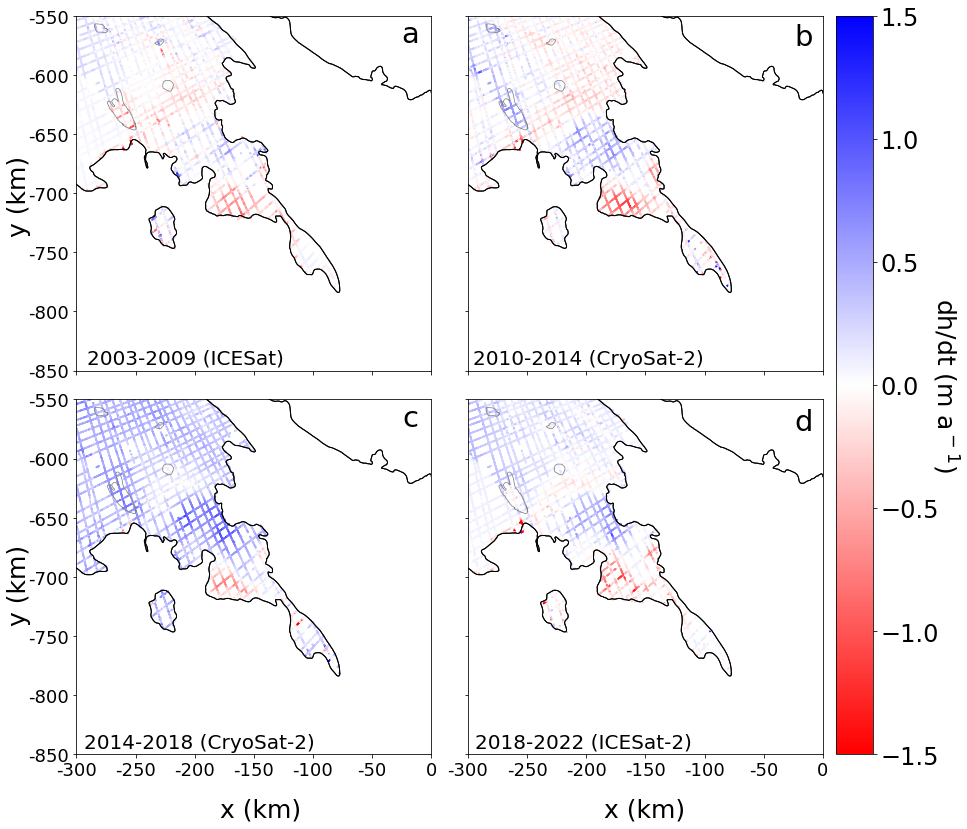

In [8]:
# Create subplots
fig2_s, axs = plt.subplots(nrows=2, ncols=2, figsize=(13,11))

# Plot lake outlines and GL
for i in range(2):
    for j in range(2):
        gdf.plot(facecolor="none", edgecolor="gray", ax=axs[i,j], zorder=2, lw=.7)
        gl.plot(facecolor="none", edgecolor="black", ax=axs[i,j], zorder=3)

# Plot ICESat points
axs[0,0].scatter(x_is_F, y_is_F, s=.6, c=dhdt_is_F, vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)
# Plot ICESat-2 points
im=axs[1,1].scatter(points_is2_18_22['x'], points_is2_18_22['y'], s=.6, c=points_is2_18_22['dhdt'], vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)

# Plot CryoSat-2 points
axs[0,1].scatter(points_cs2_10_14['x'], points_cs2_10_14['y'], s=.6, c=points_cs2_10_14['dhdt'], vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)
axs[1,0].scatter(points_cs2_14_18['x'], points_cs2_14_18['y'], s=.6, c=points_cs2_14_18['dhdt'], vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)

# Set axes limits and tick labels
for ax in axs.flat:
    ax.set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
axs[0,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs[1,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs[1,0].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
axs[1,1].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
#### Figure 2 Labels
fig2_s.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
cbar = fig2_s.colorbar(im,ax=axs.ravel().tolist(),pad=.015)
cbar.ax.get_yaxis().labelpad = 22
cbar.ax.set_ylabel('dh/dt (m a$^-$$^1$)', rotation=270,fontsize=25)
cbar.ax.tick_params(labelsize=24)

# Set common labels
fig2_s.text(0.23, -.025, 'x (km)', ha='center', va='center',fontsize=25)
fig2_s.text(-.028, 0.26, 'y (km)', ha='center', va='center', rotation='vertical',fontsize=25)
fig2_s.text(0.64, -.025, 'x (km)', ha='center', va='center',fontsize=25)
fig2_s.text(-.028, 0.75, 'y (km)', ha='center', va='center', rotation='vertical',fontsize=25)
# panel labels
fig2_s.text(0.39, 0.954, 'a', ha='center', va='center', rotation='horizontal',fontsize=29)
fig2_s.text(0.81, 0.95, 'b', ha='center', va='center', rotation='horizontal',fontsize=29)
fig2_s.text(0.39, 0.469, 'c', ha='center', va='center', rotation='horizontal',fontsize=29)
fig2_s.text(0.81, 0.465, 'd', ha='center', va='center', rotation='horizontal',fontsize=29)
# panel dates
fig2_s.text(0.15, 0.545, '2003-2009 (ICESat)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig2_s.text(0.58, 0.545, '2010-2014 (CryoSat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig2_s.text(0.165, 0.06, '2014-2018 (CryoSat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig2_s.text(0.575, 0.06, '2018-2022 (ICESat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)

# fig2_s.savefig("/Users/hannah/Documents/Research/CraryIceRise/fig2_F.png", dpi=300, format='png', metadata=None,bbox_inches='tight', pad_inches=.1)

## (b) Figure S1

### figure of entire dh/dt time series

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/4287980788.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/4287980788.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/4287980788.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/4287980788.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/4287980788.py:45: UserWarning: FixedFormatter should only be used together with Fix

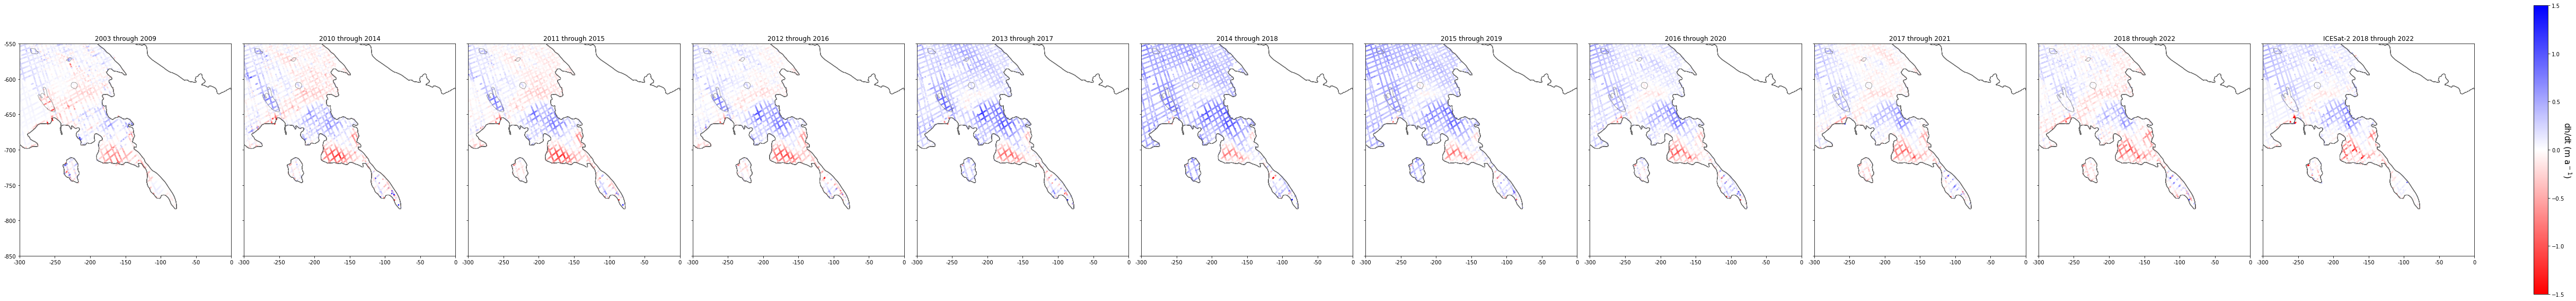

In [9]:
# This code plots the entire dh/dt time series in one row. Additional organization of this figure in Affinity Designer.

# Create subplots
figS1, axs = plt.subplots(nrows=1, ncols=11, figsize=(100,10))

# Common settings
common_settings = {
    "s": 2,
    "vmin": -1.5,
    "vmax": 1.5,
    "cmap": 'bwr_r',
    "zorder": 1
}

# Loop through each subplot
for i, (title, points) in enumerate([
    ('2003 through 2009', (x_is_F, y_is_F, dhdt_is_F)),
    ('2010 through 2014', (points_cs2_10_14['x'], points_cs2_10_14['y'], points_cs2_10_14['dhdt'])),
    ('2011 through 2015', (points_cs2_11_15['x'], points_cs2_11_15['y'], points_cs2_11_15['dhdt'])),
    ('2012 through 2016', (points_cs2_12_16['x'], points_cs2_12_16['y'], points_cs2_12_16['dhdt'])),
    ('2013 through 2017', (points_cs2_13_17['x'], points_cs2_13_17['y'], points_cs2_13_17['dhdt'])),
    ('2014 through 2018', (points_cs2_14_18['x'], points_cs2_14_18['y'], points_cs2_14_18['dhdt'])),
    ('2015 through 2019', (points_cs2_15_19['x'], points_cs2_15_19['y'], points_cs2_15_19['dhdt'])),
    ('2016 through 2020', (points_cs2_16_20['x'], points_cs2_16_20['y'], points_cs2_16_20['dhdt'])),
    ('2017 through 2021', (points_cs2_17_21['x'], points_cs2_17_21['y'], points_cs2_17_21['dhdt'])),
    ('2018 through 2022', (points_cs2_18_22['x'], points_cs2_18_22['y'], points_cs2_18_22['dhdt'])),
    ('ICESat-2 2018 through 2022', (points_is2_18_22['x'], points_is2_18_22['y'], points_is2_18_22['dhdt']))
]):
    # Unpack points
    x, y, c = points

    # Plot CryoSat-2 or ICESat-2 dhdt points
    axs[i].scatter(x, y, c=c, **common_settings)

    # Plot glacier outlines
    gl.plot(facecolor="none", edgecolor="gray", ax=axs[i], zorder=4, lw=.7)

    # Plot GL
    gl.plot(facecolor="none", edgecolor="black", ax=axs[i], zorder=3)

    # Set axes limits and tick labels
    axs[i].set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
    axs[i].title.set_text(title)
    axs[i].axes.yaxis.set_ticklabels([])
    axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))

#### Figure 2 Labels
# fig2.suptitle("Time Series of dh/dt",fontsize=20,y=.99,x=.45)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
cbar = figS1.colorbar(im,ax=axs.ravel().tolist(),pad=.02)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('dh/dt (m a$^-$$^1$)', rotation=270,fontsize=15)
axs[0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50))
for ii in range(len(axs)):
    gdf.plot(facecolor="none", edgecolor="gray",ax=axs[ii],zorder=4,lw=.7)

plt.show()

# figS1.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/figS1.pdf", dpi=300, format='pdf', metadata=None,bbox_inches=None, pad_inches=0.1)

## (c) Figure S2

### RMSE time series

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1519008332.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1519008332.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1519008332.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1519008332.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1519008332.py:46: UserWarning: FixedFormatter should only be used together with Fix

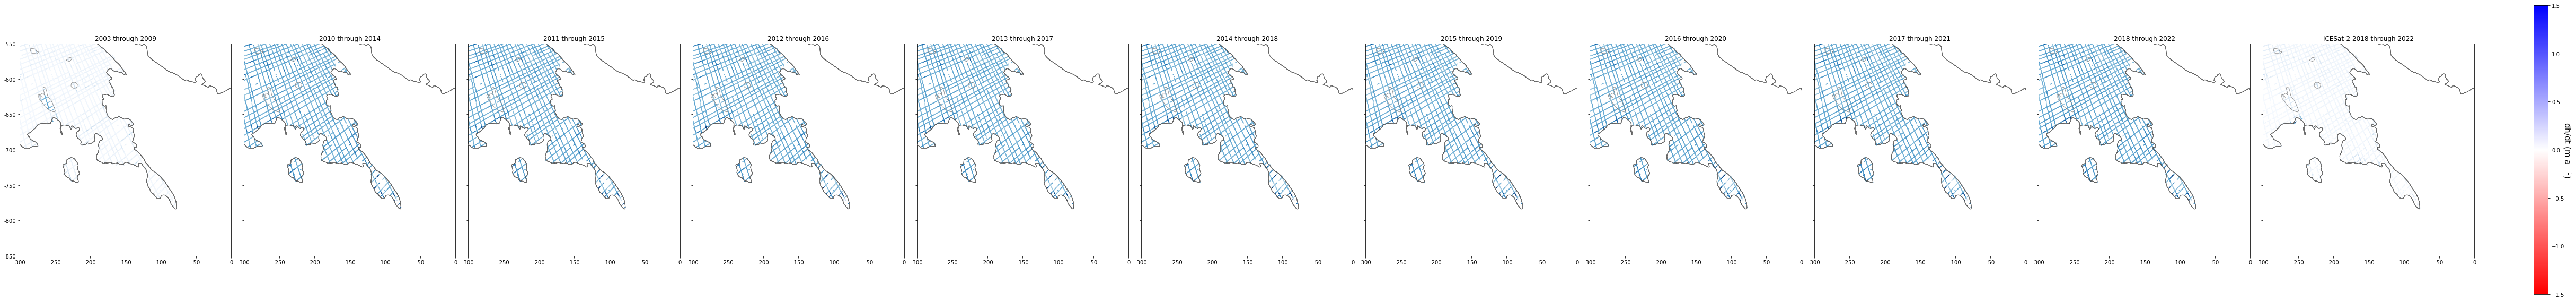

In [10]:
# This plots the RMSE of the dh/dt estimate and elevation data.
# additional organization of this figure in Affinity Designer

# Create subplots
figS2, axs = plt.subplots(nrows=1, ncols=11, figsize=(100,10))

# Common settings
common_settings = {
    "s": .2,
    "vmin": 0,
    "vmax": 5,
    "cmap": 'Blues',
    "zorder": 1
}

# Loop through each subplot
for i, (title, points) in enumerate([
    ('2003 through 2009', (x_is_F, y_is_F, rmse_is_F)),
    ('2010 through 2014', (points_cs2_10_14['x'], points_cs2_10_14['y'], points_cs2_10_14['dhdt_rms'])),
    ('2011 through 2015', (points_cs2_11_15['x'], points_cs2_11_15['y'], points_cs2_11_15['dhdt_rms'])),
    ('2012 through 2016', (points_cs2_12_16['x'], points_cs2_12_16['y'], points_cs2_12_16['dhdt_rms'])),
    ('2013 through 2017', (points_cs2_13_17['x'], points_cs2_13_17['y'], points_cs2_13_17['dhdt_rms'])),
    ('2014 through 2018', (points_cs2_14_18['x'], points_cs2_14_18['y'], points_cs2_14_18['dhdt_rms'])),
    ('2015 through 2019', (points_cs2_15_19['x'], points_cs2_15_19['y'], points_cs2_15_19['dhdt_rms'])),
    ('2016 through 2020', (points_cs2_16_20['x'], points_cs2_16_20['y'], points_cs2_16_20['dhdt_rms'])),
    ('2017 through 2021', (points_cs2_17_21['x'], points_cs2_17_21['y'], points_cs2_17_21['dhdt_rms'])),
    ('2018 through 2022', (points_cs2_18_22['x'], points_cs2_18_22['y'], points_cs2_18_22['dhdt_rms'])),
    ('ICESat-2 2018 through 2022', (points_is2_18_22['x'], points_is2_18_22['y'], points_is2_18_22['dhdt_rms']))
]):
    # Unpack points
    x, y, c = points

    # Plot CryoSat-2 or ICESat-2 dhdt points
    axs[i].scatter(x, y, c=c, **common_settings)

    # Plot glacier outlines
    gl.plot(facecolor="none", edgecolor="gray", ax=axs[i], zorder=4, lw=.7)

    # Plot GL
    gl.plot(facecolor="none", edgecolor="black", ax=axs[i], zorder=3)

    # Set axes limits and tick labels
    axs[i].set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
    axs[i].title.set_text(title)
    axs[i].axes.yaxis.set_ticklabels([])
    axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))

#### Figure 2 Labels
# fig2.suptitle("Time Series of dh/dt",fontsize=20,y=.99,x=.45)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
cbar = figS1.colorbar(im,ax=axs.ravel().tolist(),pad=.02)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('dh/dt (m a$^-$$^1$)', rotation=270,fontsize=15)
axs[0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50))
for ii in range(len(axs)):
    gdf.plot(facecolor="none", edgecolor="gray",ax=axs[ii],zorder=4,lw=.7)

plt.show()

# figS2.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/figS2.png", dpi=300, format='png', metadata=None,bbox_inches='tight', pad_inches=.1)

## (d) Fig S3

### figure of regional dh/dt means that will be removed from the raw dh/dt estimates

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/2411312952.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1.xaxis.set_ticklabels([str(i) for i in range(2003,2023)], fontsize=18, rotation=290)


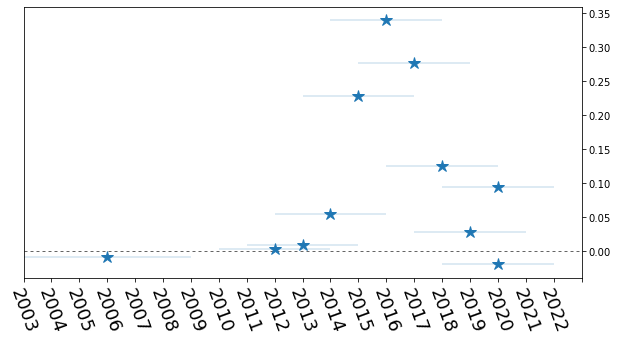

In [11]:
# This code plots a time series of regional mean dh/dt.
# additional organization of this figure in Affinity Designer

# Calculate mean values
means = [
    np.nanmean(dhdt_is_F),
    np.nanmean(points_cs2_10_14['dhdt']),
    np.nanmean(points_cs2_11_15['dhdt']),
    np.nanmean(points_cs2_12_16['dhdt']),
    np.nanmean(points_cs2_13_17['dhdt']),
    np.nanmean(points_cs2_14_18['dhdt']),
    np.nanmean(points_cs2_15_19['dhdt']),
    np.nanmean(points_cs2_16_20['dhdt']),
    np.nanmean(points_cs2_17_21['dhdt']),
    np.nanmean(points_cs2_18_22['dhdt']),
    np.nanmean(points_is2_18_22['dhdt'])
]

# Create array for average time
avgtime = np.arange(2003, 2023)
avgtime = np.insert(avgtime, 18, 2020)

# Create array for mean values with NaNs
meanvals = np.full(len(avgtime), np.nan)
meanvals[3] = means[0]
meanvals[9:11] = means[1:3]
meanvals[11:16] = means[3:8]
meanvals[16] = means[8]
meanvals[17] = means[9]
meanvals[18] = means[10]

# Plot the graph
figS2, axs1 = plt.subplots(figsize=(10,5))
axs1.axhline(y=0, xmin=0, xmax=1, c='k', alpha=1, linewidth=.6,linestyle='dashed',dashes=(5, 5))
plt.plot(avgtime, meanvals, marker='*', markersize=12, linestyle='None')
axs1.xaxis.set_ticklabels([str(i) for i in range(2003,2023)], fontsize=18, rotation=290)
axs1.yaxis.tick_right()
axs1.locator_params(axis='x', nbins=20)
axs1.set(xlim=(2003, 2023))

# Add range bars to every point
rng = np.ones(len(avgtime)) * 2
rng[3] = 3
axs1.errorbar(avgtime, meanvals, xerr=rng, fmt="none", elinewidth=0.3, alpha=1)


axs1.set(ylim=(-.04, .36))
axs1.locator_params(axis='y', nbins=8)

plt.show()

# figS3.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/figS3.pdf", dpi=300, format='pdf', metadata=None,bbox_inches=None, pad_inches=0.1)

## (e) Fig 3

### figure of dh/dt with means removed (anomalous dh/dt) at 4 time intervals

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/3668053214.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/3668053214.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/3668053214.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/3668053214.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)


Text(0.73, 0.36, '$\\widebar{\\frac{dh}{dt}} = $0.10 m a$^-$$^1$')

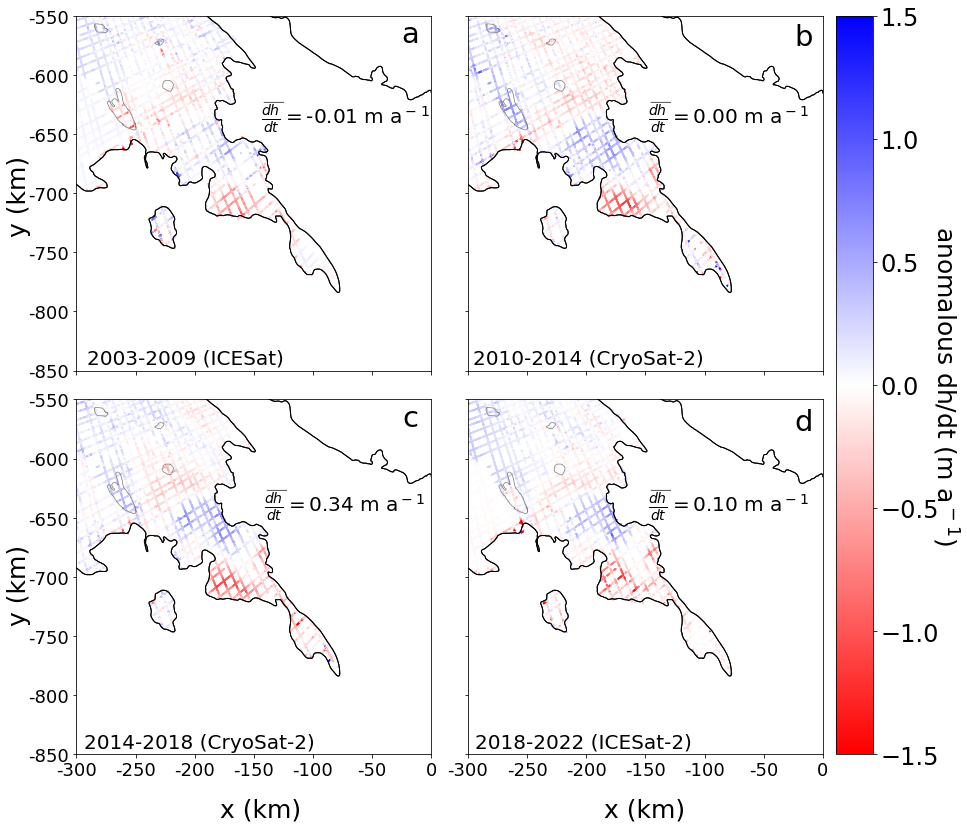

In [12]:
# Create subplots
fig3_s, axs = plt.subplots(nrows=2, ncols=2, figsize=(13,11))

# Plot lake outlines and GL
for i in range(2):
    for j in range(2):
        gdf.plot(facecolor="none", edgecolor="gray", ax=axs[i,j], zorder=2, lw=.7)
        gl.plot(facecolor="none", edgecolor="black", ax=axs[i,j], zorder=3)

# Plot ICESat points
axs[0,0].scatter(x_is_F, y_is_F, s=.6, c=dhdt_is_F-np.nanmean(dhdt_is_F), vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)
# Plot ICESat-2 points
axs[1,1].scatter(points_is2_18_22['x'], points_is2_18_22['y'], s=.6, c=points_is2_18_22['dhdt']-np.nanmean(points_is2_18_22['dhdt']), vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)

# Plot CryoSat-2 points
axs[0,1].scatter(points_cs2_10_14['x'], points_cs2_10_14['y'], s=.6, c=points_cs2_10_14['dhdt']-np.nanmean(points_cs2_10_14['dhdt']), vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)
axs[1,0].scatter(points_cs2_14_18['x'], points_cs2_14_18['y'], s=.6, c=points_cs2_14_18['dhdt']-np.nanmean(points_cs2_14_18['dhdt']), vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)

# Set axes limits and tick labels
for ax in axs.flat:
    ax.set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
axs[0,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs[1,0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs[1,0].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
axs[1,1].xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
#### Figure 2 Labels
fig3_s.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
cbar = fig3_s.colorbar(im,ax=axs.ravel().tolist(),pad=.015)
cbar.ax.get_yaxis().labelpad = 22
cbar.ax.set_ylabel('anomalous dh/dt (m a$^-$$^1$)', rotation=270,fontsize=25)
cbar.ax.tick_params(labelsize=24)

# Set common labels
fig3_s.text(0.23, -.025, 'x (km)', ha='center', va='center',fontsize=25)
fig3_s.text(-.028, 0.26, 'y (km)', ha='center', va='center', rotation='vertical',fontsize=25)
fig3_s.text(0.64, -.025, 'x (km)', ha='center', va='center',fontsize=25)
fig3_s.text(-.028, 0.75, 'y (km)', ha='center', va='center', rotation='vertical',fontsize=25)
# panel labels
fig3_s.text(0.39, 0.954, 'a', ha='center', va='center', rotation='horizontal',fontsize=29)
fig3_s.text(0.81, 0.95, 'b', ha='center', va='center', rotation='horizontal',fontsize=29)
fig3_s.text(0.39, 0.469, 'c', ha='center', va='center', rotation='horizontal',fontsize=29)
fig3_s.text(0.81, 0.465, 'd', ha='center', va='center', rotation='horizontal',fontsize=29)
# panel dates
fig3_s.text(0.15, 0.545, '2003-2009 (ICESat)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig3_s.text(0.58, 0.545, '2010-2014 (CryoSat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig3_s.text(0.165, 0.06, '2014-2018 (CryoSat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)
fig3_s.text(0.575, 0.06, '2018-2022 (ICESat-2)', ha='center', va='center', rotation='horizontal',fontsize=20)

# mean values per panel 'Sigmoid(%s)'%(a)   
fig3_s.text(0.32, 0.85, '$\\widebar{\\frac{dh}{dt}} = $' +str(round(np.nanmean(dhdt_is_F),2))+ ' m a$^-$$^1$', ha='center', va='center', rotation='horizontal',fontsize=20)
fig3_s.text(0.73, 0.85, '$\\widebar{\\frac{dh}{dt}} = $' +str(round(np.nanmean(points_cs2_10_14['dhdt']),2))+ '0 m a$^-$$^1$', ha='center', va='center', rotation='horizontal',fontsize=20)
# fig3_s.text(0.72, 0.83, '$\overline{dh/dt}$ m a$^-$$^1$', ha='center', va='center', rotation='horizontal',fontsize=18)
fig3_s.text(0.32, 0.36,'$\\widebar{\\frac{dh}{dt}} = $' +str(round(np.nanmean(points_cs2_14_18['dhdt']),2))+ ' m a$^-$$^1$', ha='center', va='center', rotation='horizontal',fontsize=20)
fig3_s.text(0.73, 0.36,'$\\widebar{\\frac{dh}{dt}} = $' +str(round(np.nanmean(points_is2_18_22['dhdt']),2))+ '0 m a$^-$$^1$', ha='center', va='center', rotation='horizontal',fontsize=20)

# fig3_s.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/fig3.pdf", dpi=300, format='pdf', metadata=None,bbox_inches=None, pad_inches=0.1)

## (f) Fig S4

### figure of entire dh/dt time series with regional means removed (anomalous dh/dt)

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/325996057.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/325996057.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/325996057.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/325996057.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/325996057.py:45: UserWarning: FixedFormatter should only be used together with FixedLoc

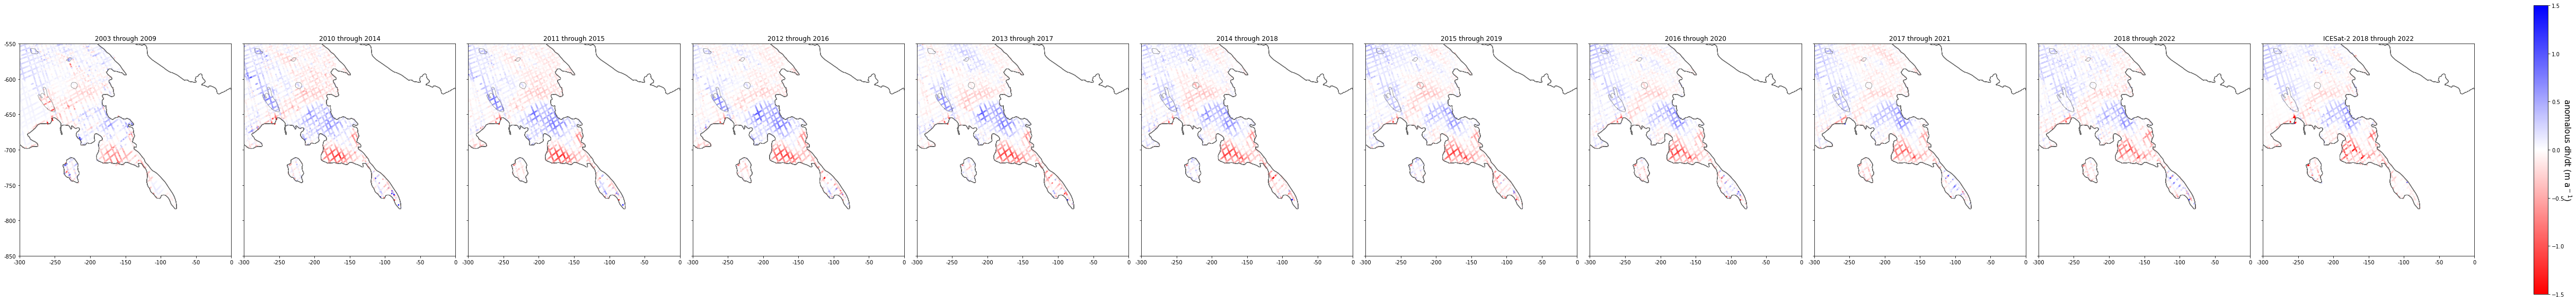

In [13]:
# This code plots the entire dh/dt time series in one row. Additional organization of this figure in Affinity Designer.

# Create subplots
figS4, axs = plt.subplots(nrows=1, ncols=11, figsize=(100,10))

# Common settings
common_settings = {
    "s": 2,
    "vmin": -1.5,
    "vmax": 1.5,
    "cmap": 'bwr_r',
    "zorder": 1
}

# Loop through each subplot
for i, (title, points) in enumerate([
    ('2003 through 2009', (x_is_F, y_is_F, dhdt_is_F-np.nanmean(dhdt_is_F))),
    ('2010 through 2014', (points_cs2_10_14['x'], points_cs2_10_14['y'], points_cs2_10_14['dhdt']-np.nanmean(points_cs2_10_14['dhdt']))),
    ('2011 through 2015', (points_cs2_11_15['x'], points_cs2_11_15['y'], points_cs2_11_15['dhdt']-np.nanmean(points_cs2_11_15['dhdt']))),
    ('2012 through 2016', (points_cs2_12_16['x'], points_cs2_12_16['y'], points_cs2_12_16['dhdt']-np.nanmean(points_cs2_12_16['dhdt']))),
    ('2013 through 2017', (points_cs2_13_17['x'], points_cs2_13_17['y'], points_cs2_13_17['dhdt']-np.nanmean(points_cs2_13_17['dhdt']))),
    ('2014 through 2018', (points_cs2_14_18['x'], points_cs2_14_18['y'], points_cs2_14_18['dhdt']-np.nanmean(points_cs2_14_18['dhdt']))),
    ('2015 through 2019', (points_cs2_15_19['x'], points_cs2_15_19['y'], points_cs2_15_19['dhdt']-np.nanmean(points_cs2_15_19['dhdt']))),
    ('2016 through 2020', (points_cs2_16_20['x'], points_cs2_16_20['y'], points_cs2_16_20['dhdt']-np.nanmean(points_cs2_16_20['dhdt']))),
    ('2017 through 2021', (points_cs2_17_21['x'], points_cs2_17_21['y'], points_cs2_17_21['dhdt']-np.nanmean(points_cs2_17_21['dhdt']))),
    ('2018 through 2022', (points_cs2_18_22['x'], points_cs2_18_22['y'], points_cs2_18_22['dhdt']-np.nanmean(points_cs2_18_22['dhdt']))),
    ('ICESat-2 2018 through 2022', (points_is2_18_22['x'], points_is2_18_22['y'], points_is2_18_22['dhdt']-np.nanmean(points_is2_18_22['dhdt'])))
]):
    # Unpack points
    x, y, c = points

    # Plot CryoSat-2 or ICESat-2 dhdt points
    axs[i].scatter(x, y, c=c, **common_settings)

    # Plot glacier outlines
    gl.plot(facecolor="none", edgecolor="gray", ax=axs[i], zorder=4, lw=.7)

    # Plot GL
    gl.plot(facecolor="none", edgecolor="black", ax=axs[i], zorder=3)

    # Set axes limits and tick labels
    axs[i].set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
    axs[i].title.set_text(title)
    axs[i].axes.yaxis.set_ticklabels([])
    axs[i].xaxis.set_ticklabels(np.arange(-300, 50, 50))

#### Figure 2 Labels
# fig2.suptitle("Time Series of dh/dt",fontsize=20,y=.99,x=.45)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
cbar = figS4.colorbar(im,ax=axs.ravel().tolist(),pad=.02)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('anomalous dh/dt (m a$^-$$^1$)', rotation=270,fontsize=15)
axs[0].axes.yaxis.set_ticklabels(np.arange(-850,-500,50))
for ii in range(len(axs)):
    gdf.plot(facecolor="none", edgecolor="gray",ax=axs[ii],zorder=4,lw=.7)

plt.show()

# figS4.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/figS4.pdf", dpi=300, format='pdf', metadata=None,bbox_inches=None, pad_inches=0.1)

## (g) Fig 4

### figure of mean signals within delineated boundaries. For questions about boundary delineation technique, contact Wilson Sauthoff (sauthoff@mines.edu). Boundary delineation is part of an in-prep manuscript.

In [14]:
### analysis of timeseries within delineated polygons

## define polygon list
poly_mean_dhdt_IS = []
poly_mean_dhdt_CS2_10_14 = []
poly_mean_dhdt_CS2_11_15 = []
poly_mean_dhdt_CS2_12_16 = []
poly_mean_dhdt_CS2_13_17 = []
poly_mean_dhdt_CS2_14_18 = []
poly_mean_dhdt_CS2_15_19 = []
poly_mean_dhdt_CS2_16_20 = []
poly_mean_dhdt_CS2_17_21 = []
poly_mean_dhdt_CS2_18_22 = []
poly_mean_dhdt_IS2 = []

## define stdev list
poly_std_dhdt_IS = []
poly_std_dhdt_CS2_10_14 = []
poly_std_dhdt_CS2_11_15 = []
poly_std_dhdt_CS2_12_16 = []
poly_std_dhdt_CS2_13_17 = []
poly_std_dhdt_CS2_14_18 = []
poly_std_dhdt_CS2_15_19 = []
poly_std_dhdt_CS2_16_20 = []
poly_std_dhdt_CS2_17_21 = []
poly_std_dhdt_CS2_18_22 = []
poly_std_dhdt_IS2 = []


polygons = [pol_crst,pol_poslg,pol_negGL,pol_negsp]

for p in range(len(polygons)):
    
    polygon = polygons[p]
    
    ptis_dhdt=np.empty([len(gdf1_F)])*np.nan
    ptcs_1014_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1115_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1216_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1317_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1418_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1519_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1620_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1721_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1822_dhdt=np.empty([len(gdf2)])*np.nan
    ptis2_dhdt=np.empty([len(gdf2)])*np.nan
    
    for i in range(len(gdf1_F)):
        point=gdf1_F.coords[i]
        if sum(polygon.contains(point))==1:
            ptis_dhdt[i]=dhdt_is_F[i]
    
    for i in range(len(gdf2)):       
        point=gdf2.coords[i]
        if sum(polygon.contains(point))==1:
            ptcs_1014_dhdt[i]=points_cs2_10_14['dhdt'][i]
            ptcs_1115_dhdt[i]=points_cs2_11_15['dhdt'][i]
            ptcs_1216_dhdt[i]=points_cs2_12_16['dhdt'][i]
            ptcs_1317_dhdt[i]=points_cs2_13_17['dhdt'][i]
            ptcs_1418_dhdt[i]=points_cs2_14_18['dhdt'][i]
            ptcs_1519_dhdt[i]=points_cs2_15_19['dhdt'][i]
            ptcs_1620_dhdt[i]=points_cs2_16_20['dhdt'][i]
            ptcs_1721_dhdt[i]=points_cs2_17_21['dhdt'][i]
            ptcs_1822_dhdt[i]=points_cs2_18_22['dhdt'][i]
            ptis2_dhdt[i]=points_is2_18_22['dhdt'][i]

    poly_mean_dhdt_IS.append(np.nanmean(ptis_dhdt-np.nanmean(dhdt_is_F)))
    poly_mean_dhdt_CS2_10_14.append(np.nanmean(ptcs_1014_dhdt-np.nanmean(points_cs2_10_14['dhdt'])))
    poly_mean_dhdt_CS2_11_15.append(np.nanmean(ptcs_1115_dhdt-np.nanmean(points_cs2_11_15['dhdt'])))
    poly_mean_dhdt_CS2_12_16.append(np.nanmean(ptcs_1216_dhdt-np.nanmean(points_cs2_12_16['dhdt'])))
    poly_mean_dhdt_CS2_13_17.append(np.nanmean(ptcs_1317_dhdt-np.nanmean(points_cs2_13_17['dhdt'])))
    poly_mean_dhdt_CS2_14_18.append(np.nanmean(ptcs_1418_dhdt-np.nanmean(points_cs2_14_18['dhdt'])))
    poly_mean_dhdt_CS2_15_19.append(np.nanmean(ptcs_1519_dhdt-np.nanmean(points_cs2_15_19['dhdt'])))
    poly_mean_dhdt_CS2_16_20.append(np.nanmean(ptcs_1620_dhdt-np.nanmean(points_cs2_16_20['dhdt'])))
    poly_mean_dhdt_CS2_17_21.append(np.nanmean(ptcs_1721_dhdt-np.nanmean(points_cs2_17_21['dhdt'])))
    poly_mean_dhdt_CS2_18_22.append(np.nanmean(ptcs_1822_dhdt-np.nanmean(points_cs2_18_22['dhdt'])))
    poly_mean_dhdt_IS2.append(np.nanmean(ptis2_dhdt-np.nanmean(points_is2_18_22['dhdt'])))
    
    poly_std_dhdt_IS.append(np.nanstd(ptis_dhdt-np.nanmean(dhdt_is_F)))
    poly_std_dhdt_CS2_10_14.append(np.nanstd(ptcs_1014_dhdt-np.nanmean(points_cs2_10_14['dhdt'])))
    poly_std_dhdt_CS2_11_15.append(np.nanstd(ptcs_1115_dhdt-np.nanmean(points_cs2_11_15['dhdt'])))
    poly_std_dhdt_CS2_12_16.append(np.nanstd(ptcs_1216_dhdt-np.nanmean(points_cs2_12_16['dhdt'])))
    poly_std_dhdt_CS2_13_17.append(np.nanstd(ptcs_1317_dhdt-np.nanmean(points_cs2_13_17['dhdt'])))
    poly_std_dhdt_CS2_14_18.append(np.nanstd(ptcs_1418_dhdt-np.nanmean(points_cs2_14_18['dhdt'])))
    poly_std_dhdt_CS2_15_19.append(np.nanstd(ptcs_1519_dhdt-np.nanmean(points_cs2_15_19['dhdt'])))
    poly_std_dhdt_CS2_16_20.append(np.nanstd(ptcs_1620_dhdt-np.nanmean(points_cs2_16_20['dhdt'])))
    poly_std_dhdt_CS2_17_21.append(np.nanstd(ptcs_1721_dhdt-np.nanmean(points_cs2_17_21['dhdt'])))
    poly_std_dhdt_CS2_18_22.append(np.nanstd(ptcs_1822_dhdt-np.nanmean(points_cs2_18_22['dhdt'])))
    poly_std_dhdt_IS2.append(np.nanstd(ptis2_dhdt-np.nanmean(points_is2_18_22['dhdt'])))
        
# polygons = [pol_crst,pol_poslg,pol_negGL,pol_negsp]      
poly_df = pd.DataFrame(data={'Polygon':['Crescent','Positive (Dipole)','Negative (new GZ)','Negative space (GZ retreat)'],'Mean_2003_2009':poly_mean_dhdt_IS,'Mean_2010_2014':poly_mean_dhdt_CS2_10_14,'Mean_2011_2015':poly_mean_dhdt_CS2_11_15,'Mean_2012_2016':poly_mean_dhdt_CS2_12_16,'Mean_2013_2017':poly_mean_dhdt_CS2_13_17,'Mean_2014_2018':poly_mean_dhdt_CS2_14_18,'Mean_2015_2019':poly_mean_dhdt_CS2_15_19,'Mean_2016_2020':poly_mean_dhdt_CS2_16_20,'Mean_2017_2021':poly_mean_dhdt_CS2_17_21,'Mean_2018_2022 CS2':poly_mean_dhdt_CS2_18_22,'Mean_2018_2022 IS2':poly_mean_dhdt_IS2})

poly_df_std = pd.DataFrame(data={'Polygon':['Crescent','Positive (Dipole)','Negative (new GZ)','Negative space (GZ retreat)'],'STD_2003_2009':poly_std_dhdt_IS,'STD_2010_2014':poly_std_dhdt_CS2_10_14,'STD_2011_2015':poly_std_dhdt_CS2_11_15,'STD_2012_2016':poly_std_dhdt_CS2_12_16,'STD_2013_2017':poly_std_dhdt_CS2_13_17,'STD_2014_2018':poly_std_dhdt_CS2_14_18,'STD_2015_2019':poly_std_dhdt_CS2_15_19,'STD_2016_2020':poly_std_dhdt_CS2_16_20,'STD_2017_2021':poly_std_dhdt_CS2_17_21,'STD_2018_2022 CS2':poly_std_dhdt_CS2_18_22,'STD_2018_2022 IS2':poly_std_dhdt_IS2})


/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/715536024.py:36: RuntimeWarning: invalid value encountered in multiply
  ptis_dhdt=np.empty([len(gdf1_F)])*np.nan
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/715536024.py:43: RuntimeWarning: invalid value encountered in multiply
  ptcs_1620_dhdt=np.empty([len(gdf2)])*np.nan


/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1873165094.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs0.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1873165094.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs0.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1873165094.py:44: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1873165094.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[3].xaxis.set_ticklabels([str(i) for i in range(2003,2023)],fontsize=18,rotation=290)
/var/folders/0y/cdm8mcn11sn1lh28

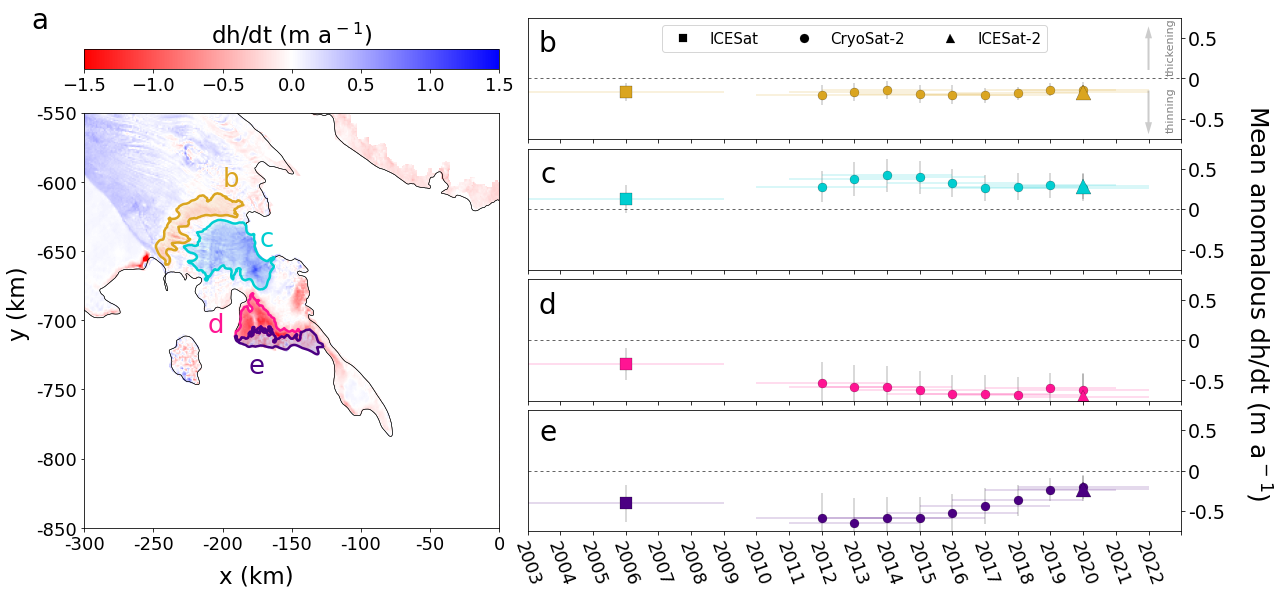

In [15]:
### FIGURE 4
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
fig = plt.figure(layout="constrained")
fig.set_figheight(8)
fig.set_figwidth(17)
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[.7, 1])

# icesat-2 atl15 plot
axs0 = subfigs[0].subplots()
im=axs0.imshow(z_,vmin=-1.5,vmax=1.5,cmap='bwr_r',alpha=1,extent = [-3e5, 0, -8.5e5, -5.5e5],origin='lower',zorder=1)
# GL
df=gpd.read_file("/Users/hannah/Documents/Research/CraryIceRise/ICESatCodes/scripps/scripps_antarctica_polygons_v1.shp")
df.plot(facecolor="none", edgecolor="black",ax=axs0,zorder=3,lw=.5)

# plot polygons
pol_crst.plot(facecolor="goldenrod", edgecolor="none",ax=axs0,zorder=3,alpha=.1)
pol_poslg.plot(facecolor="darkturquoise", edgecolor="none",ax=axs0,zorder=3,alpha=.1)
pol_negGL.plot(facecolor="deeppink", edgecolor="none",ax=axs0,zorder=3,alpha=.1)
pol_negsp.plot(facecolor="indigo", edgecolor="none",ax=axs0,zorder=3,alpha=.2)

pol_crst.plot(facecolor="none", edgecolor="goldenrod",lw=2.5,ax=axs0,zorder=4,alpha=1)
pol_poslg.plot(facecolor="none", edgecolor="darkturquoise",lw=2.5,ax=axs0,zorder=4,alpha=1)
pol_negGL.plot(facecolor="none", edgecolor="deeppink",lw=2.5,ax=axs0,zorder=4,alpha=1)
pol_negsp.plot(facecolor="none", edgecolor="indigo",lw=2.5,ax=axs0,zorder=4,alpha=1)
# Ross ice shelf
iceshelf.loc[[990],'geometry'].plot(facecolor="white",alpha=1,ax=axs0,zorder=2)

# background & labels
subfigs[0].supxlabel('x (km)',fontsize=23)
subfigs[0].supylabel('y (km)',fontsize=23)
axs0.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
axs0.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs0.set(xlim=(-3e5,0), ylim=(-8.5e5, -5.5e5))

# colorbar
divider = make_axes_locatable(axs0)
cax = divider.new_vertical(size = '5%', pad = 0.6)
subfigs[0].add_axes(cax)
cbar = subfigs[0].colorbar(im,cax = cax,orientation = 'horizontal',ax=axs0,pad=.04,shrink=0.3)
cbar.ax.get_yaxis().labelpad = 2.3
cbar.ax.set_title('dh/dt (m a$^-$$^1$)',fontsize=23)
cbar.ax.tick_params(labelsize=18)
cbar.set_alpha(1)
cbar.draw_all()

# mean plots
axs1 = subfigs[1].subplots(4, 1)

# titles & labels
axs1[3].xaxis.set_ticklabels([str(i) for i in range(2003,2023)],fontsize=18,rotation=290)
axs1[3].yaxis.tick_right()
axs1[0].xaxis.set_ticklabels([]);axs1[0].yaxis.tick_right()
axs1[1].xaxis.set_ticklabels([]);axs1[1].yaxis.tick_right()
axs1[2].xaxis.set_ticklabels([]);axs1[2].yaxis.tick_right()
subfigs[1].supylabel('Mean anomalous dh/dt (m a$^-$$^1$)',x=1.02,rotation=270,fontsize=25)
axs1[0].yaxis.set_ticklabels([str(i) for i in [-0.75,-0.5,0,0.5]],fontsize=19)
axs1[1].yaxis.set_ticklabels([str(i) for i in [-0.75,-0.5,0,0.5]],fontsize=19)
axs1[2].yaxis.set_ticklabels([str(i) for i in [-0.75,-0.5,0,0.5]],fontsize=19)
axs1[3].yaxis.set_ticklabels([str(i) for i in [-0.75,-0.5,0,0.5]],fontsize=19)

# plot values
avgtime = np.arange(2003,2022)
avgtime = np.insert(avgtime, 18, 2020)
zero = np.zeros(len(avgtime));
colors=["goldenrod","darkturquoise","deeppink","indigo"]

for i in range(len(axs1)):
    axs1[i].axhline(y=0, xmin=0, xmax=1,c='k',alpha=1,linewidth=.6,linestyle='dashed',dashes=(5, 5))
    
    meds=[np.nan,np.nan,np.nan,poly_df['Mean_2003_2009'][i],np.nan,np.nan,np.nan,np.nan,np.nan,poly_df['Mean_2010_2014'][i],poly_df['Mean_2011_2015'][i],poly_df['Mean_2012_2016'][i],poly_df['Mean_2013_2017'][i],poly_df['Mean_2014_2018'][i],poly_df['Mean_2015_2019'][i],poly_df['Mean_2016_2020'][i],poly_df['Mean_2017_2021'][i],poly_df['Mean_2018_2022 CS2'][i],poly_df['Mean_2018_2022 IS2'][i],np.nan]
    std=[np.nan,np.nan,np.nan,poly_df_std['STD_2003_2009'][i],np.nan,np.nan,np.nan,np.nan,np.nan,poly_df_std['STD_2010_2014'][i],poly_df_std['STD_2011_2015'][i],poly_df_std['STD_2012_2016'][i],poly_df_std['STD_2013_2017'][i],poly_df_std['STD_2014_2018'][i],poly_df_std['STD_2015_2019'][i],poly_df_std['STD_2016_2020'][i],poly_df_std['STD_2017_2021'][i],poly_df_std['STD_2018_2022 CS2'][i],poly_df_std['STD_2018_2022 IS2'][i],np.nan]
    
    axs1[i].errorbar(avgtime,meds, yerr=std, fmt="none",ecolor='black',elinewidth=0.3)
    axs1[i].plot(avgtime[3],meds[3],colors[i],marker='s',markersize=12,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='ICESat')
    axs1[i].plot(avgtime[4:18],meds[4:18],colors[i],marker='.',markersize=18,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='CryoSat-2')
    axs1[i].plot(avgtime[18],meds[18],colors[i],marker='^',markersize=15,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='ICESat-2')
   
    # add range bars to every point
    rng= np.ones(len(avgtime))*2
    rng[3]=3
    axs1[i].errorbar(avgtime,meds, xerr=rng, fmt="none",ecolor=colors[i],elinewidth=0.3,alpha=1)
    
    axs1[i].set(ylim=(-.75, .75))
    axs1[i].locator_params(axis='y', nbins=4)
    axs1[i].locator_params(axis='x', nbins=20)
    axs1[i].set(xlim=(2003, 2023))

# thickening thinning annotations
subfigs[1].text(.92, .945, 'thickening', ha='center', va='center', rotation='vertical',fontsize=11,c='grey')
subfigs[1].text(.92, .836, 'thinning', ha='center', va='center', rotation='vertical',fontsize=11,c='grey')


axs1[0].annotate('', xy=(0.95, .95), xycoords='axes fraction',
            xytext=(0.95, .55), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='grey',edgecolor='none',width=2,headwidth=7,shrink=0.05,alpha=.4))

axs1[0].annotate('', xy=(0.95, .02), xycoords='axes fraction',
            xytext=(0.95, .42), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='grey',edgecolor='none',width=2,headwidth=7,shrink=0.05,alpha=.4))

# panel labels
subfigs[0].text(.07, .99, 'a', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.055, .95, 'b', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.055, .723, 'c', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.055, .495, 'd', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.055, .275, 'e', ha='center', va='center', rotation='horizontal',fontsize=28)

subfigs[0].text(.45, .715, 'b', ha='center', va='center', rotation='horizontal',fontsize=26,color=colors[0])
subfigs[0].text(.52, .61, 'c', ha='center', va='center', rotation='horizontal',fontsize=26,color=colors[1])
subfigs[0].text(.42, .46, 'd', ha='center', va='center', rotation='horizontal',fontsize=26,color=colors[2])
subfigs[0].text(.5, .39, 'e', ha='center', va='center', rotation='horizontal',fontsize=26,color=colors[3])

# legend
axs1[0].legend(loc='upper center',ncol=3,fontsize=15)
leg = axs1[0].get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')
leg.legendHandles[0].set_markersize(8)
leg.legendHandles[2].set_markersize(9)

# fig.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/fig4_F.png", dpi=300, format='png',bbox_inches='tight', metadata=None, pad_inches=0.1)

## (h) Fig 5

### figure of anomalous mass estimates

In [16]:
### Analysis of time series within delineated polygons

## define polygon list
poly_mean_dhdt_IS = []
poly_mean_dhdt_CS2_10_14 = []
poly_mean_dhdt_CS2_11_15 = []
poly_mean_dhdt_CS2_12_16 = []
poly_mean_dhdt_CS2_13_17 = []
poly_mean_dhdt_CS2_14_18 = []
poly_mean_dhdt_CS2_15_19 = []
poly_mean_dhdt_CS2_16_20 = []
poly_mean_dhdt_CS2_17_21 = []
poly_mean_dhdt_CS2_18_22 = []
poly_mean_dhdt_IS2 = []

## define stdev list
poly_std_dhdt_IS = []
poly_std_dhdt_CS2_10_14 = []
poly_std_dhdt_CS2_11_15 = []
poly_std_dhdt_CS2_12_16 = []
poly_std_dhdt_CS2_13_17 = []
poly_std_dhdt_CS2_14_18 = []
poly_std_dhdt_CS2_15_19 = []
poly_std_dhdt_CS2_16_20 = []
poly_std_dhdt_CS2_17_21 = []
poly_std_dhdt_CS2_18_22 = []
poly_std_dhdt_IS2 = []


polygons = [WIP,LCIR,POS,NEG,pol_negGL,pol_negsp]

for p in range(len(polygons)):
    
    polygon = polygons[p]
    
    ptis_dhdt=np.empty([len(gdf1_F)])*np.nan
    ptcs_1014_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1115_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1216_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1317_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1418_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1519_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1620_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1721_dhdt=np.empty([len(gdf2)])*np.nan
    ptcs_1822_dhdt=np.empty([len(gdf2)])*np.nan
    ptis2_dhdt=np.empty([len(gdf2)])*np.nan
    
    for i in range(len(gdf1_F)):
        point=gdf1_F.coords[i]
        if sum(polygon.contains(point))==1:
            ptis_dhdt[i]=dhdt_is_F[i]
    
    for i in range(len(gdf2)):       
        point=gdf2.coords[i]
        if sum(polygon.contains(point))==1:
            ptcs_1014_dhdt[i]=points_cs2_10_14['dhdt'][i]
            ptcs_1115_dhdt[i]=points_cs2_11_15['dhdt'][i]
            ptcs_1216_dhdt[i]=points_cs2_12_16['dhdt'][i]
            ptcs_1317_dhdt[i]=points_cs2_13_17['dhdt'][i]
            ptcs_1418_dhdt[i]=points_cs2_14_18['dhdt'][i]
            ptcs_1519_dhdt[i]=points_cs2_15_19['dhdt'][i]
            ptcs_1620_dhdt[i]=points_cs2_16_20['dhdt'][i]
            ptcs_1721_dhdt[i]=points_cs2_17_21['dhdt'][i]
            ptcs_1822_dhdt[i]=points_cs2_18_22['dhdt'][i]
            ptis2_dhdt[i]=points_is2_18_22['dhdt'][i]
        
    poly_mean_dhdt_IS.append(np.nanmean(ptis_dhdt-np.nanmean(dhdt_is_F)))
    poly_mean_dhdt_CS2_10_14.append(np.nanmean(ptcs_1014_dhdt-np.nanmean(points_cs2_10_14['dhdt'])))
    poly_mean_dhdt_CS2_11_15.append(np.nanmean(ptcs_1115_dhdt-np.nanmean(points_cs2_11_15['dhdt'])))
    poly_mean_dhdt_CS2_12_16.append(np.nanmean(ptcs_1216_dhdt-np.nanmean(points_cs2_12_16['dhdt'])))
    poly_mean_dhdt_CS2_13_17.append(np.nanmean(ptcs_1317_dhdt-np.nanmean(points_cs2_13_17['dhdt'])))
    poly_mean_dhdt_CS2_14_18.append(np.nanmean(ptcs_1418_dhdt-np.nanmean(points_cs2_14_18['dhdt'])))
    poly_mean_dhdt_CS2_15_19.append(np.nanmean(ptcs_1519_dhdt-np.nanmean(points_cs2_15_19['dhdt'])))
    poly_mean_dhdt_CS2_16_20.append(np.nanmean(ptcs_1620_dhdt-np.nanmean(points_cs2_16_20['dhdt'])))
    poly_mean_dhdt_CS2_17_21.append(np.nanmean(ptcs_1721_dhdt-np.nanmean(points_cs2_17_21['dhdt'])))
    poly_mean_dhdt_CS2_18_22.append(np.nanmean(ptcs_1822_dhdt-np.nanmean(points_cs2_18_22['dhdt'])))
    poly_mean_dhdt_IS2.append(np.nanmean(ptis2_dhdt-np.nanmean(points_is2_18_22['dhdt'])))
    
    
    poly_std_dhdt_IS.append(np.nanstd(ptis_dhdt-np.nanmean(dhdt_is_F)))
    poly_std_dhdt_CS2_10_14.append(np.nanstd(ptcs_1014_dhdt-np.nanmean(points_cs2_10_14['dhdt'])))
    poly_std_dhdt_CS2_11_15.append(np.nanstd(ptcs_1115_dhdt-np.nanmean(points_cs2_11_15['dhdt'])))
    poly_std_dhdt_CS2_12_16.append(np.nanstd(ptcs_1216_dhdt-np.nanmean(points_cs2_12_16['dhdt'])))
    poly_std_dhdt_CS2_13_17.append(np.nanstd(ptcs_1317_dhdt-np.nanmean(points_cs2_13_17['dhdt'])))
    poly_std_dhdt_CS2_14_18.append(np.nanstd(ptcs_1418_dhdt-np.nanmean(points_cs2_14_18['dhdt'])))
    poly_std_dhdt_CS2_15_19.append(np.nanstd(ptcs_1519_dhdt-np.nanmean(points_cs2_15_19['dhdt'])))
    poly_std_dhdt_CS2_16_20.append(np.nanstd(ptcs_1620_dhdt-np.nanmean(points_cs2_16_20['dhdt'])))
    poly_std_dhdt_CS2_17_21.append(np.nanstd(ptcs_1721_dhdt-np.nanmean(points_cs2_17_21['dhdt'])))
    poly_std_dhdt_CS2_18_22.append(np.nanstd(ptcs_1822_dhdt-np.nanmean(points_cs2_18_22['dhdt'])))
    poly_std_dhdt_IS2.append(np.nanstd(ptis2_dhdt-np.nanmean(points_is2_18_22['dhdt'])))
             
poly_df = pd.DataFrame(data={'Polygon':['WIP','LCIR','POS','NEG','NEWNEG','NEGSP'],'Mean_2003_2009':poly_mean_dhdt_IS,'Mean_2010_2014':poly_mean_dhdt_CS2_10_14,'Mean_2011_2015':poly_mean_dhdt_CS2_11_15,'Mean_2012_2016':poly_mean_dhdt_CS2_12_16,'Mean_2013_2017':poly_mean_dhdt_CS2_13_17,'Mean_2014_2018':poly_mean_dhdt_CS2_14_18,'Mean_2015_2019':poly_mean_dhdt_CS2_15_19,'Mean_2016_2020':poly_mean_dhdt_CS2_16_20,'Mean_2017_2021':poly_mean_dhdt_CS2_17_21,'Mean_2018_2022 CS2':poly_mean_dhdt_CS2_18_22,'Mean_2018_2022 IS2':poly_mean_dhdt_IS2})
poly_df_std = pd.DataFrame(data={'Polygon':['WIP','LCIR','POS','NEG','NEWNEG','NEGSP'],'STD_2003_2009':poly_std_dhdt_IS,'STD_2010_2014':poly_std_dhdt_CS2_10_14,'STD_2011_2015':poly_std_dhdt_CS2_11_15,'STD_2012_2016':poly_std_dhdt_CS2_12_16,'STD_2013_2017':poly_std_dhdt_CS2_13_17,'STD_2014_2018':poly_std_dhdt_CS2_14_18,'STD_2015_2019':poly_std_dhdt_CS2_15_19,'STD_2016_2020':poly_std_dhdt_CS2_16_20,'STD_2017_2021':poly_std_dhdt_CS2_17_21,'STD_2018_2022 CS2':poly_std_dhdt_CS2_18_22,'STD_2018_2022 IS2':poly_std_dhdt_IS2})

# now that i have dhdt within the sub-regions, i can use the MB equation to get MB
MB_arr=[[np.nan for _ in range(11)] for _ in range(4)]
# WIP
MB_arr[0][:]=[mass_balance(poly_mean_dhdt_IS[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_10_14[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_11_15[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_12_16[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_13_17[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_14_18[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_15_19[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_16_20[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_17_21[0],WIP.area[0]),mass_balance(poly_mean_dhdt_CS2_18_22[0],WIP.area[0]),mass_balance(poly_mean_dhdt_IS2[0],WIP.area[0])]
# LCIR
MB_arr[1][:]=[mass_balance(poly_mean_dhdt_IS[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_10_14[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_11_15[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_12_16[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_13_17[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_14_18[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_15_19[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_16_20[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_17_21[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_CS2_18_22[1],LCIR.area[0]),mass_balance(poly_mean_dhdt_IS2[1],LCIR.area[0])]
# POS
MB_arr[2][:]=[mass_balance(poly_mean_dhdt_IS[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_10_14[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_11_15[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_12_16[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_13_17[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_14_18[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_15_19[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_16_20[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_17_21[2],POS.area[0]),mass_balance(poly_mean_dhdt_CS2_18_22[2],POS.area[0]),mass_balance(poly_mean_dhdt_IS2[2],POS.area[0])]
# NEG
MB_arr[3][:]=[mass_balance(poly_mean_dhdt_IS[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_10_14[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_11_15[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_12_16[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_13_17[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_14_18[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_15_19[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_16_20[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_17_21[3],NEG.area[0]),mass_balance(poly_mean_dhdt_CS2_18_22[3],NEG.area[0]),mass_balance(poly_mean_dhdt_IS2[3],NEG.area[0])]


# now that i have dhdt within the sub-regions, i can use the MB equation to get MB st.dev
MB_arr_std=[[np.nan for _ in range(11)] for _ in range(4)]
# WIP
MB_arr_std[0][:]=[mass_balance(poly_std_dhdt_IS[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_10_14[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_11_15[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_12_16[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_13_17[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_14_18[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_15_19[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_16_20[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_17_21[0],WIP.area[0]),mass_balance(poly_std_dhdt_CS2_18_22[0],WIP.area[0]),mass_balance(poly_std_dhdt_IS2[0],WIP.area[0])]
# LCIR
MB_arr_std[1][:]=[mass_balance(poly_std_dhdt_IS[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_10_14[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_11_15[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_12_16[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_13_17[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_14_18[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_15_19[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_16_20[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_17_21[1],LCIR.area[0]),mass_balance(poly_std_dhdt_CS2_18_22[1],LCIR.area[0]),mass_balance(poly_std_dhdt_IS2[1],LCIR.area[0])]
# POS
MB_arr_std[2][:]=[mass_balance(poly_std_dhdt_IS[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_10_14[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_11_15[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_12_16[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_13_17[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_14_18[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_15_19[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_16_20[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_17_21[2],POS.area[0]),mass_balance(poly_std_dhdt_CS2_18_22[2],POS.area[0]),mass_balance(poly_std_dhdt_IS2[2],POS.area[0])]
# NEG
MB_arr_std[3][:]=[mass_balance(poly_std_dhdt_IS[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_10_14[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_11_15[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_12_16[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_13_17[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_14_18[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_15_19[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_16_20[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_17_21[3],NEG.area[0]),mass_balance(poly_std_dhdt_CS2_18_22[3],NEG.area[0]),mass_balance(poly_std_dhdt_IS2[3],NEG.area[0])]


/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1885528611.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs0.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1885528611.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs0.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1885528611.py:43: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_63249/1885528611.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs1[3].xaxis.set_ticklabels([str(i) for i in range(2003,2023)],fontsize=18,rotation=290)
/var/folders/0y/cdm8mcn11sn1lh28

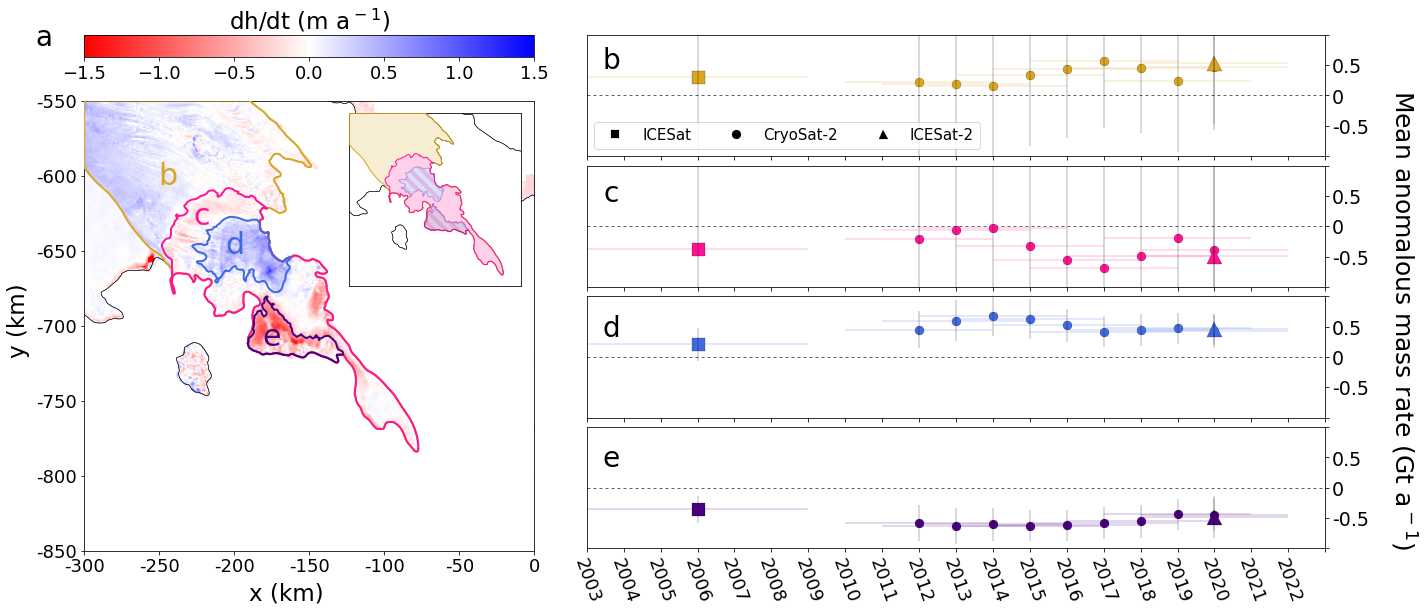

In [17]:
## make a plot to compare rates

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
figMB = plt.figure(layout="constrained")
figMB.set_figheight(8)
figMB.set_figwidth(19)
subfigs = figMB.subfigures(1, 2, wspace=0, width_ratios=[.7, 1])

# icesat-2 atl15 plot
axs0 = subfigs[0].subplots()
im=axs0.imshow(z_,vmin=-1.5,vmax=1.5,cmap='bwr_r',alpha=1,extent = [-3e5, 0, -8.5e5, -5.5e5],origin='lower',zorder=1)

# GL
df=gpd.read_file("/Users/hannah/Documents/Research/CraryIceRise/ICESatCodes/scripps/scripps_antarctica_polygons_v1.shp")
df.plot(facecolor="none", edgecolor="black",ax=axs0,zorder=3,lw=.5)

MB_cutoff.plot(facecolor="none", edgecolor="deeppink",ax=axs0,zorder=6,alpha=1,lw=2)
CIR_region.plot(facecolor="none", edgecolor="goldenrod",ax=axs0,zorder=5,alpha=1,lw=2)
# rumple.plot(facecolor="none", edgecolor="goldenrod",ax=axs0,zorder=5,alpha=1,lw=2)
pol_poslg.plot(facecolor="none", edgecolor="royalblue",ax=axs0,zorder=7,alpha=1,lw=2)
NEG.plot(facecolor="none",edgecolor="indigo",ax=axs0,zorder=7,alpha=1,lw=2)

# Ross ice shelf
iceshelf.loc[[990],'geometry'].plot(facecolor="white",alpha=1,ax=axs0,zorder=2)

# background & labels
# subfigs[0].set_facecolor('0.98')
subfigs[0].supxlabel('x (km)',fontsize=23)
subfigs[0].supylabel('y (km)',fontsize=23)
axs0.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=18)
axs0.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=18)
axs0.set(xlim=(-3e5,0), ylim=(-8.5e5, -5.5e5))

# # colorbar
divider = make_axes_locatable(axs0)
cax = divider.new_vertical(size = '5%', pad = 0.6)
subfigs[0].add_axes(cax)
cbar = subfigs[0].colorbar(im,cax = cax,orientation = 'horizontal',ax=axs0,pad=.04,shrink=0.3)
cbar.ax.get_yaxis().labelpad = 2.3
cbar.ax.set_title('dh/dt (m a$^-$$^1$)',fontsize=23)
cbar.ax.tick_params(labelsize=18)
cbar.set_alpha(1)
cbar.draw_all()


#### inset legend
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset_axes = inset_axes(axs0,
                    width=2.4,                     # inch
                    height=2.4,                    # inch
                    bbox_transform=axs0.transData, # data coordinates
                    bbox_to_anchor=(-127000,-677000),    # data coordinates
                    loc=3)                       # loc=lower left corner
#GL
df.plot(facecolor="none", edgecolor="black",ax=inset_axes,zorder=3,lw=.5)

#polygons
plt.rcParams["hatch.linewidth"] = 4
MB_cutoff.plot(facecolor="white", edgecolor="none",ax=inset_axes,zorder=5,alpha=1)
MB_cutoff.plot(facecolor="deeppink", edgecolor="none",ax=inset_axes,zorder=5,alpha=.2)
CIR_region.plot(facecolor="goldenrod", edgecolor="none",ax=inset_axes,zorder=4,alpha=.2)
pol_poslg.plot(facecolor="white", edgecolor="none",ax=inset_axes,zorder=6,alpha=1)
pol_poslg.plot(facecolor="royalblue", edgecolor="deeppink",ax=inset_axes,zorder=6,alpha=.2,hatch=r"\\")
NEG.plot(facecolor="white", edgecolor="none",ax=inset_axes,zorder=6,alpha=1)
NEG.plot(facecolor="indigo",edgecolor="deeppink",ax=inset_axes,zorder=6,alpha=.2,hatch=r"\\")

MB_cutoff.plot(facecolor="none", edgecolor="deeppink",ax=inset_axes,zorder=6,alpha=1)
CIR_region.plot(facecolor="none", edgecolor="goldenrod",ax=inset_axes,zorder=5,alpha=1)
pol_poslg.plot(facecolor="none", edgecolor="royalblue",ax=inset_axes,zorder=7,alpha=.3)
NEG.plot(facecolor="none",edgecolor="indigo",ax=inset_axes,zorder=7,alpha=.3)

# Ross ice shelf
iceshelf.loc[[990],'geometry'].plot(facecolor="white",alpha=1,ax=inset_axes,zorder=2)

# background & labels
inset_axes.xaxis.set_ticklabels([])
inset_axes.yaxis.set_ticklabels([])
inset_axes.tick_params(bottom = False,left = False)
inset_axes.set(xlim=(-3e5,-51000), ylim=(-8e5, -5.5e5))

###

## MB plots
axs1 = subfigs[1].subplots(4, 1)
# titles & labels
axs1[3].xaxis.set_ticklabels([str(i) for i in range(2003,2023)],fontsize=18,rotation=290)
axs1[3].yaxis.tick_right()
axs1[0].xaxis.set_ticklabels([]);axs1[0].yaxis.tick_right()
axs1[1].xaxis.set_ticklabels([]);axs1[1].yaxis.tick_right()
axs1[2].xaxis.set_ticklabels([]);axs1[2].yaxis.tick_right()
subfigs[1].supylabel('Mean anomalous mass rate (Gt a$^-$$^1$)',x=1.02,rotation=270,fontsize=25)
axs1[0].yaxis.set_ticklabels([str(i) for i in ['',-0.5,0,0.5,'']],fontsize=19)
axs1[1].yaxis.set_ticklabels([str(i) for i in ['',-0.5,0,0.5,'']],fontsize=19)
axs1[2].yaxis.set_ticklabels([str(i) for i in ['',-0.5,0,0.5,'']],fontsize=19)
axs1[3].yaxis.set_ticklabels([str(i) for i in ['',-0.5,0,0.5,'']],fontsize=19)

# plot values
avgtime = np.arange(2003,2022)
avgtime = np.insert(avgtime, 18, 2020)
zero = np.zeros(len(avgtime))
colors=["goldenrod","deeppink","royalblue","indigo"]

for i in range(len(axs1)):
    axs1[i].axhline(y=0, xmin=0, xmax=1,c='k',alpha=1,linewidth=.6,linestyle='dashed',dashes=(5, 5))


    std=[np.nan,np.nan,np.nan,MB_arr_std[i][0],np.nan,np.nan,np.nan,np.nan,np.nan,MB_arr_std[i][1],MB_arr_std[i][2],MB_arr_std[i][3],MB_arr_std[i][4],MB_arr_std[i][5],MB_arr_std[i][6],MB_arr_std[i][7],MB_arr_std[i][8],MB_arr_std[i][9],MB_arr_std[i][10],np.nan]
    
    MB=[np.nan,np.nan,np.nan,MB_arr[i][0],np.nan,np.nan,np.nan,np.nan,np.nan,MB_arr[i][1],MB_arr[i][2],MB_arr[i][3],MB_arr[i][4],MB_arr[i][5],MB_arr[i][6],MB_arr[i][7],MB_arr[i][8],MB_arr[i][9],MB_arr[i][10],np.nan]
    sq=axs1[i].plot(avgtime[3],MB[3],colors[i],marker='s',markersize=13,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='ICESat')
    dot=axs1[i].plot(avgtime[4:18],MB[4:18],colors[i],marker='.',markersize=18,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='CryoSat-2')
    tri=axs1[i].plot(avgtime[18],MB[18],colors[i],marker='^',markersize=15,linestyle = 'None',markeredgecolor='black',markeredgewidth=0.2,label='ICESat-2')
  
    axs1[i].errorbar(avgtime,MB, yerr=std, fmt="none",ecolor='black',elinewidth=0.3)
    # add range bars to every point
    rng= np.ones(len(avgtime))*2
    rng[3]=3
    axs1[i].errorbar(avgtime,MB, xerr=rng, fmt="none",ecolor=colors[i],elinewidth=0.3,alpha=1)
    axs1[i].set(ylim=(-1, 1))
    axs1[i].locator_params(axis='y', nbins=5)
    axs1[i].locator_params(axis='x', nbins=20)
    axs1[i].set(xlim=(2003, 2023))
        
# panel labels
subfigs[0].text(.07, .99, 'a', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.054, .95, 'b', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.054, .72, 'c', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.054, .485, 'd', ha='center', va='center', rotation='horizontal',fontsize=28)
subfigs[1].text(.054, .26, 'e', ha='center', va='center', rotation='horizontal',fontsize=28)

subfigs[0].text(.29, .75, 'b', ha='center', va='center', rotation='horizontal',fontsize=30,color=colors[0])
subfigs[0].text(.35, .68, 'c', ha='center', va='center', rotation='horizontal',fontsize=30,color=colors[1])
subfigs[0].text(.41, .63, 'd', ha='center', va='center', rotation='horizontal',fontsize=30,color=colors[2])
subfigs[0].text(.475, .47, 'e', ha='center', va='center', rotation='horizontal',fontsize=30,color=colors[3])


# legend
axs1[0].legend(loc='lower left',ncol=3,fontsize=15)
leg = axs1[0].get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')
leg.legendHandles[0].set_markersize(8)
leg.legendHandles[2].set_markersize(9)

# figMB.savefig("/Users/hannah/Documents/Research/CraryIceRise/PAPER/FIGURES_Paper/fig5_F.png", dpi=300, format='png', metadata=None,bbox_inches='tight', pad_inches=.1)